# Multiclass classification

In [6]:
%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute
from classification.classification import classify_all
from data_reading.phyphox import read_experiments_in_dir
from features import extract_timeseries_features
from file_handling import get_sub_directories
from preprocessing import preprocess_chunks_for_multiclass_test_one_handed, concat_chunks_for_feature_extraction, \
    segment_for_null_classification


sample_rate = 50

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of classification.classification failed: Traceback (most recent call last):
  File "/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/julio/Documents/Uni/5_Master/Master Project/mp-men

In [20]:
# config:

experiment_dir_path = "../../data/phyphox/full recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
use_indoor = False
window_size = 50
# MinimalFCParameters, ComprehensiveFCParameters, EfficientFCParameters
feature_calculation_setting = MinimalFCParameters()

# Ana-2, Ariane, Julian, Wiki
experiment_dirs_selected = ["Ana-2","Ariane","Julian","Wiktoria"]
#experiment_dirs_selected = ["Julius"]
experiment_dirs = [exp_dir for exp_dir in experiment_dirs if exp_dir.split("/")[-1] in experiment_dirs_selected]

Preprocess data

In [21]:
chunks, null_chunks, y = read_experiments_in_dir(experiment_dirs, sample_rate, drop_lin_acc=True)

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_data_frame.py:31: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  time_delta_index = pd.TimedeltaIndex(timestamp_to_date, unit=output_timestamp_unit)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
chunks_ocd, chunks_null_class, y_ocd = preprocess_chunks_for_multiclass_test_one_handed(chunks, null_chunks, y, use_indoor)

In [23]:
chunks_ocd[1]

,gyroscope x,gyroscope y,gyroscope z,acceleration x,acceleration y,acceleration z,action_id
index,,,,,,,
00:00:50.009891,0.299355,-0.404462,0.298486,5.319927,5.084093,6.251681,1
00:00:50.029891,0.283659,-0.564500,0.363297,5.428931,4.955667,6.628238,1
00:00:50.049891,0.228926,-0.545697,0.365058,5.185529,5.136183,6.784716,1
00:00:50.069891,0.253488,-0.502188,0.322827,5.602077,5.305484,6.513440,1
00:00:50.089891,0.278720,-0.694445,0.410786,5.761780,5.498893,6.192763,1
...,...,...,...,...,...,...,...
00:00:54.789891,-0.029257,0.055905,-0.072715,2.734126,4.664709,8.253884,1
00:00:54.809891,-0.021256,0.084662,-0.093862,2.647030,4.763625,8.169458,1
00:00:54.829891,-0.023252,0.088731,-0.097459,2.651617,4.834449,8.185848,1


In [ ]:
labels = y_ocd.loc[:, "label"].squeeze()
assert len(labels) == len(chunks_ocd)

labels_ocd_multiclass = labels.reset_index(drop=True)
chunks_ocd_segmented, labels_ocd_segmented_multiclass, chunks_null_segmented, labels_null_segmented = segment_for_null_classification(chunks_ocd, chunks_null_class, window_size, labels)

assert len(set(labels_ocd_multiclass)) == len(set(labels_ocd_segmented_multiclass))

In [18]:
assert len(labels_ocd_segmented_multiclass) == len(chunks_ocd_segmented)

# with null class
multi_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented_multiclass, labels_null_segmented])

assert len(labels_multi_class_classification) == len(chunks_ocd_segmented) + len(chunks_null_segmented)
assert len(multi_class_df.loc[:, "action_id"].unique()) == len(chunks_ocd_segmented) + len(chunks_null_segmented)

assert len(set(labels_multi_class_classification)) == labels.nunique() + 1
# without null class
"""
multi_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented],
        [labels_ocd_segmented_multiclass])
"""
assert len(set(labels_multi_class_classification)) == len(set(labels_ocd_segmented_multiclass)) + 1

7516


In [20]:
# the one handed activities
assert set(labels_multi_class_classification) == {'checking oven',
 'cleaning leg',
 'cleaning table',
 'cleaning window',
 'null class',
 'pulling door',
 'pulling hair',
 'pushing door',}

### Feature extraction for multi class OCD activities incl null

In [21]:
X_multi_class_classification = extract_timeseries_features(multi_class_df, use_indoor=use_indoor, feature_set_config=feature_calculation_setting)

Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


In [53]:
import pandas as pd
print(pd.Series(multi_class_df.loc[:, "action_id"].unique()))

0          (0, 0)
1          (0, 1)
2          (0, 2)
3          (0, 3)
4          (1, 0)
          ...    
6883    (1238, 1)
6884     (931, 0)
6885     (931, 1)
6886    (1239, 0)
6887    (1239, 1)
Length: 6888, dtype: object


### Feature selection for multi class OCD activities incl null

In [26]:
X_multi_class_classification.head()
# TODO: something seems to be weird about the length of the chunks. Some have a length of 200, others 100 and others only 50


impute(X_multi_class_classification)
X_multi_class_classification_selected = select_features(X_multi_class_classification, set(labels_multi_class_classification))

AssertionError: The type of target vector y must be one of: pandas.Series, numpy.ndarray

In [24]:
X_multi_class_classification_selected

,acceleration y__median,acceleration y__mean,acceleration y__sum_values,acceleration y__minimum,acceleration y__maximum,acceleration x__maximum,acceleration x__mean,acceleration x__sum_values,acceleration x__median,acceleration x__minimum,...,gyroscope z__minimum,gyroscope z__maximum,gyroscope x__minimum,gyroscope x__maximum,acceleration z__maximum,minor,acceleration z__sum_values,acceleration z__mean,acceleration z__median,acceleration z__minimum
id,,,,,,,,,,,,,,,,,,,,,
"(0, 0)",4.690540,4.711675,235.583759,3.879274,5.721251,5.480186,4.639928,231.996383,4.790815,3.585152,...,-0.341074,0.136636,-0.200415,0.366613,7.625434,6.0,363.497753,7.269955,7.286851,6.880318
"(0, 1)",4.434830,4.455922,222.796088,4.278487,4.800302,5.703636,5.361053,268.052674,5.393883,4.999616,...,-0.125392,0.101273,-0.198078,0.087702,7.064303,6.0,347.243879,6.944878,6.963700,6.784823
"(0, 2)",4.621745,4.661723,233.086158,4.319319,5.049294,5.574845,5.342564,267.128200,5.310844,5.142085,...,-0.084738,0.127797,-0.114419,0.303804,7.124888,5.0,344.730046,6.894601,6.957274,6.525636
"(0, 3)",4.613159,4.669841,233.492068,4.256895,5.117954,5.617421,5.197827,259.891355,5.214433,4.788994,...,-0.191839,0.122563,-0.220643,0.013407,7.446005,6.0,347.117445,6.942349,6.870549,6.527321
"(1, 0)",4.260324,4.393756,219.687811,3.137254,6.251878,10.154037,7.440667,372.033365,7.420933,5.185529,...,-0.020072,0.505471,-0.069364,0.299355,6.784716,6.0,227.372838,4.547457,4.576939,2.616862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(1237, 1)",0.445649,0.372851,18.642562,-0.422890,1.155741,0.658143,-0.138250,-6.912524,-0.198044,-0.852834,...,-0.175462,0.011521,-0.068700,0.457737,10.218323,5.0,494.114489,9.882290,9.889692,9.605565
"(1238, 0)",-2.095280,-2.083938,-104.196887,-3.299408,-1.154603,3.184940,1.864970,93.248489,1.861640,0.748580,...,-0.464809,0.411647,0.023032,0.762520,10.877425,5.0,482.650725,9.653015,9.550438,9.036803
"(1238, 1)",-1.247659,-1.247211,-62.360538,-1.450163,-0.885582,1.982647,0.951541,47.577070,0.870566,0.699313,...,-0.117477,0.207017,-0.021881,0.186750,9.934421,5.0,487.559234,9.751185,9.746658,9.372339


In [ ]:
scaler = StandardScaler()
X_multi_class_classification_scaled = scaler.fit_transform(X_multi_class_classification_selected)

### Train models and score results

Multi class classification: using indoor: True; FC params: MinimalFCParameters; window_size 50
Logistic Regression: 0.92 +/- 0.00
['checking oven', 'cleaning leg', 'cleaning table', 'cleaning window', 'null class', 'pulling door', 'pulling hair', 'pushing door']
LDA: 0.90 +/- 0.02
['checking oven', 'cleaning leg', 'cleaning table', 'cleaning window', 'null class', 'pulling door', 'pulling hair', 'pushing door']
LinearSVC: 0.92 +/- 0.00
['checking oven', 'cleaning leg', 'cleaning table', 'cleaning window', 'null class', 'pulling door', 'pulling hair', 'pushing door']
CART: 0.78 +/- 0.05
['checking oven', 'cleaning leg', 'cleaning table', 'cleaning window', 'null class', 'pulling door', 'pulling hair', 'pushing door']
Random Forest: 0.88 +/- 0.03
['checking oven', 'cleaning leg', 'cleaning table', 'cleaning window', 'null class', 'pulling door', 'pulling hair', 'pushing door']
NB: 0.30 +/- 0.08
['checking oven', 'cleaning leg', 'cleaning table', 'cleaning window', 'null class', 'pulling 

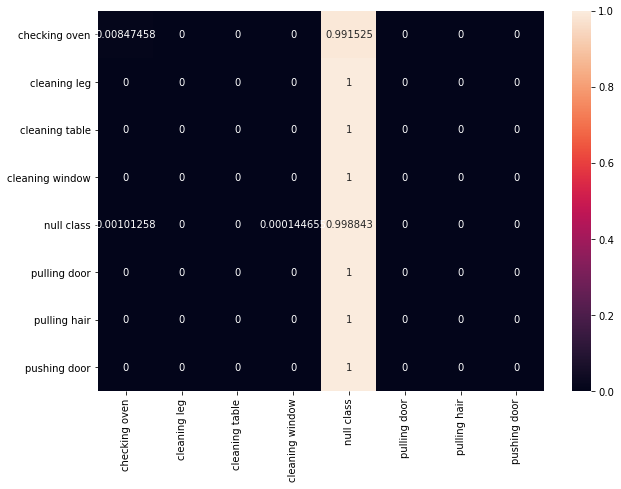

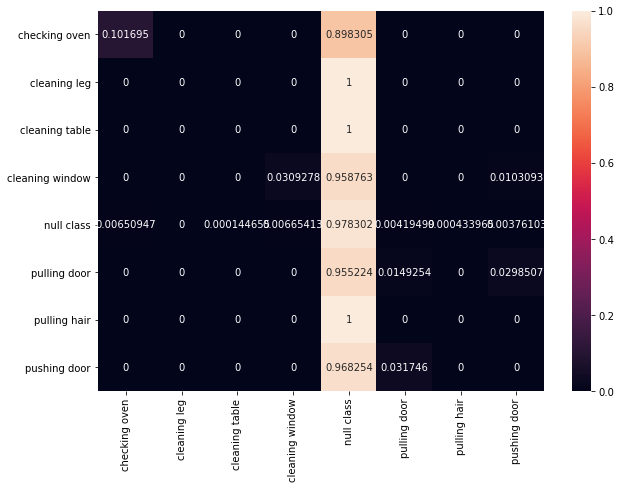

/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/p

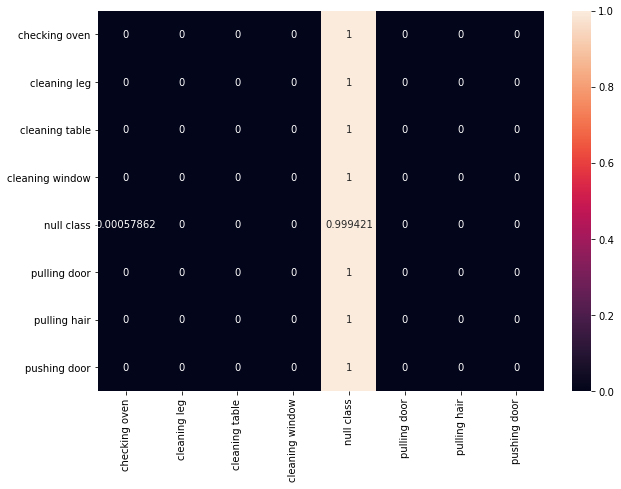

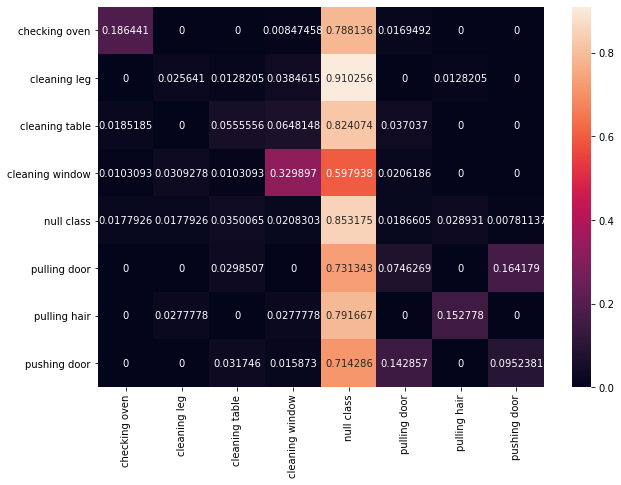

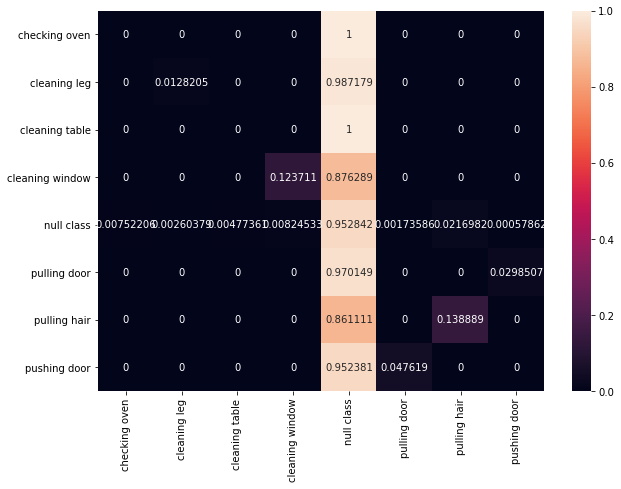

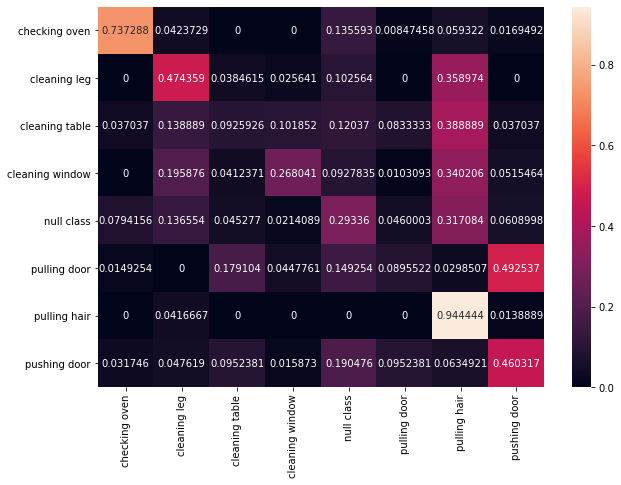

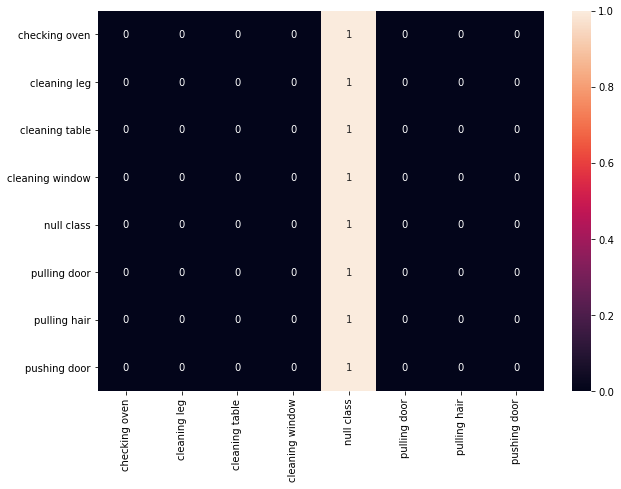

In [33]:
print("Multi class classification: using indoor: {}; FC params: {}; window_size {}".format(use_indoor,feature_calculation_setting.__class__.__name__, window_size))
classify_all(X_multi_class_classification_scaled, labels_multi_class_classification)

In [38]:
from visualization._visualization import pca_2d, sne_2d
pca_2d(X_multi_class_classification_scaled, labels_multi_class_classification, labels_multi_class_classification.unique(), ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'])


KeyboardInterrupt: 

In [36]:
labels_multi_class_classification.unique()

array(['pulling door', 'pushing door', 'checking oven', 'pulling hair',
       'cleaning leg', 'cleaning window', 'cleaning table', 'null class'],
      dtype=object)

In [41]:
len(labels_null_segmented)/ len(labels_multi_class_classification)

0.9197711548696115